# Scientific Computation on Sagemaker

Amazon SageMaker is a fully-managed service that enables developers and data scientists to quickly and easily build, train, and deploy machine learning models at any scale. But besides streamlining the machine learning workflow, SageMaker also provides a powerful, flexible and easy to use compute environment to execute and parallelize a large spectrum of scientific computing tasks. In this notebook we demostrate how to simulate a simple quantum system using Amazon SageMaker.

In [1]:
from scipy import sparse
import numpy as np
import boto3
import os
import pickle
import matplotlib.pyplot as plt

steps = 10
N = 3 # Number of nuclear spins
dim = 2**(N+1) # Dimension of Hilbert space of N nuclear and 1 electronic spin



In [2]:
rhoI = sparse.csr_matrix(([1.],([0],[0])),shape =(int(dim/2),int(dim/2))) # All nuclear spins up
rhoS = sparse.csr_matrix(([1.],([1],[1])),shape =(2,2))                   # Electron spin down
sparse_rho =sparse.kron(rhoS, rhoI)

tempfile = '/tmp/tmp.pckl'
pickle.dump(sparse_rho, open(tempfile, "wb"))

resource = boto3.resource('s3') 
my_bucket = resource.Bucket('sagemaker-kessle31') #subsitute this for your s3 bucket name. 
my_bucket.upload_file(tempfile, Key='superradiance/initial_state/init.pckl')

os.remove(tempfile) #clean-up 

In [154]:
import boto3

import os
import numpy as np
import pandas as pd
from sagemaker import get_execution_role
import sagemaker as sage
from time import gmtime, strftime


role = get_execution_role()
sess = sage.Session()
imagename = 'superradiance'

account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name
image = '{}.dkr.ecr.{}.amazonaws.com/{}'.format(account, region, imagename)

superradiance = sage.estimator.Estimator(image,
                       role, 1, 'ml.c4.2xlarge',
                       output_path="s3://sagemaker-kessle31/superradiance/output",
                       sagemaker_session=sess)

superradiance.hyperparam_dict = {'N': N, 'steps': steps}

superradiance.fit("s3://sagemaker-kessle31/superradiance/initial_state")

INFO:sagemaker:Creating training-job with name: superradiance-2018-01-17-19-55-42-602


.......................................................
Starting the training.
['init.npy', 'init.pckl', 'test.npy', 'index.html']
2018-01-17 20:00:08.015033: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
Training complete.
===== Job Complete =====


In [5]:
import tarfile

results = my_bucket.Object('superradiance/output/{}/output/model.tar.gz'.format(superradiance.latest_training_job.name))
tempfile = '/tmp/model.tar.gz'
   
results.download_file('/tmp/model.tar.gz')    


tar = tarfile.open(tempfile, "r:gz")
tar.extractall(path = '/tmp')
out = pickle.load(open('/tmp/out.pckl', "rb"))

intensity = out['intensity']
I_ind = out['I_ind']

os.remove(tempfile) #clean-up 
os.remove('/tmp/out.pckl')

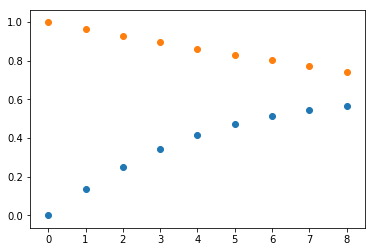

In [9]:
#plt.scatter(range(steps),polarization)
plt.scatter(range(steps-1),intensity/I_ind)
plt.scatter(range(steps-1), np.exp(-I_ind/N * np.arange(steps-1)))
plt.show()